In [1]:
from utils import *
from tqdm import tqdm
import argparse
import scipy
import multiprocessing as mp
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
class GraphConvolution(nn.Module):
    def __init__(self, n_in, n_out, bias=True):
        super(GraphConvolution, self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in,  n_out)
    def forward(self, x, adj):
        out = self.linear(x)
        return F.elu(torch.spmm(adj, out))


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, layers, dropout):
        super(GCN, self).__init__()
        self.layers = layers
        self.nhid = nhid
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConvolution(nfeat,  nhid))
        self.dropout = nn.Dropout(dropout)
        for i in range(layers-1):
            self.gcs.append(GraphConvolution(nhid,  nhid))
    def forward(self, x, adjs):
        '''
            The difference here with the original GCN implementation is that
            we will receive different adjacency matrix for different layer.
        '''
        for idx in range(len(self.gcs)):
            x = self.dropout(self.gcs[idx](x, adjs[idx]))
        return x
    
class attenGCN(nn.Module):
    def __init__(self, nfeat, nhid, layers, dropout):
        super(denseGCN, self).__init__()
        self.layers = layers
        self.nhid = nhid
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConvolution(nfeat,  nhid))
        self.atten = nn.Parameter(torch.ones(size=(nhid, 1)))
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
        for i in range(layers-1):
            self.gcs.append(GraphConvolution(nhid,  nhid))
            
    def forward(self, x, adjs):
        emb = []      
        for idx in range(len(self.gcs)):
            if idx == 0:
                emb += [self.dropout(self.gcs[idx](x, adjs[idx]))]
            else:
                emb += [self.dropout(self.gcs[idx](emb[-1], adjs[idx]))]
            
            if len(self.gcs) > 1:
                all_emb = torch.stack(emb)
                e = self.leakyrelu(torch.matmul(all_emb, self.atten).squeeze(2))              
                attention = F.softmax(e, dim=0).unsqueeze(2).repeat(1,1,self.nhid)
                output = torch.sum(attention*all_emb, dim=0)
            else:
                output = emb[-1]
            
        return output

class SuGCN(nn.Module):
    def __init__(self, encoder, num_classes, dropout, inp):
        super(SuGCN, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Linear(self.encoder.nhid, num_classes)
    def forward(self, feat, adjs):
        x = self.encoder(feat, adjs)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [3]:
batch_size = 64
cuda = 0
dataset = "cora"
sample_method = "full"
samp_num = 64
nhid = 256
epoch_num = 100
pool_num = 10
batch_num = 10
n_layers = 5
n_iters = 1
n_stops = 200

In [4]:
def default_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    mx = sparse_mx_to_torch_sparse_tensor(lap_matrix)
    return [mx for i in range(depth)], np.arange(num_nodes), batch_nodes
def prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    jobs = []
    for _ in process_ids:
        idx = torch.randperm(len(train_nodes))[:batch_size]
        batch_nodes = train_nodes[idx]
        p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes,samp_num_list, num_nodes, lap_matrix, depth))
        jobs.append(p)
    idx = torch.randperm(len(valid_nodes))[:batch_size]
    batch_nodes = valid_nodes[idx]
    p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes, samp_num_list * 20, num_nodes, lap_matrix, depth))
    jobs.append(p)
    return jobs
def package_mxl(mxl, device):
    return [torch.sparse.FloatTensor(mx[0], mx[1], mx[2]).to(device) for mx in mxl]


In [6]:
if cuda != -1:
    device = torch.device("cuda:" + str(cuda))
else:
    device = torch.device("cpu")
    
print(dataset, sample_method)
edges, labels, feat_data, num_classes, train_nodes, valid_nodes, test_nodes = load_data(dataset)

adj_matrix = get_adj(edges, feat_data.shape[0])

lap_matrix = row_normalize(adj_matrix + sp.eye(adj_matrix.shape[0]))
if type(feat_data) == scipy.sparse.lil.lil_matrix:
    feat_data = torch.FloatTensor(feat_data.todense()).to(device) 
else:
    feat_data = torch.FloatTensor(feat_data).to(device)
labels    = torch.LongTensor(labels).to(device)

sampler = default_sampler
GCN = attenGCN

cora full


In [12]:
nlayers = range(10)
test_acc_GCN = []
for n_layer in nlayers:
    n_layers = n_layer + 1
    process_ids = np.arange(batch_num)
    samp_num_list = np.array([samp_num, samp_num, samp_num, samp_num, samp_num])

    pool = mp.Pool(pool_num)
    jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, n_layers)

    all_res = []
    for oiter in range(5):
        encoder = GCN(nfeat = feat_data.shape[1], nhid=nhid, layers=n_layers, dropout = 0.2).to(device)
        susage  = SuGCN(encoder = encoder, num_classes=num_classes, dropout=0.5, inp = feat_data.shape[1])
        susage.to(device)

        optimizer = optim.Adam(filter(lambda p : p.requires_grad, susage.parameters()))
        best_val = 0
        best_tst = -1
        cnt = 0
        times = []
        res   = []
        print('-' * 10)
        for epoch in np.arange(epoch_num):
            susage.train()
            train_losses = []
            train_data = [job.get() for job in jobs[:-1]]
            valid_data = jobs[-1].get()
            pool.close()
            pool.join()
            pool = mp.Pool(pool_num)
            '''
                Use CPU-GPU cooperation to reduce the overhead for sampling. (conduct sampling while training)
            '''
            jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, n_layers)
            for _iter in range(n_iters):
                for adjs, input_nodes, output_nodes in train_data:    
                    adjs = package_mxl(adjs, device)
                    optimizer.zero_grad()
                    t1 = time.time()
                    susage.train()
                    output = susage.forward(feat_data[input_nodes], adjs)
                    if sample_method == 'full':
                        output = output[output_nodes]
                    loss_train = F.cross_entropy(output, labels[output_nodes])
                    loss_train.backward()
                    torch.nn.utils.clip_grad_norm_(susage.parameters(), 0.2)
                    optimizer.step()
                    times += [time.time() - t1]
                    train_losses += [loss_train.detach().tolist()]
                    del loss_train
            susage.eval()
            adjs, input_nodes, output_nodes = valid_data
            adjs = package_mxl(adjs, device)
            output = susage.forward(feat_data[input_nodes], adjs)
            if sample_method == 'full':
                output = output[output_nodes]
            loss_valid = F.cross_entropy(output, labels[output_nodes]).detach().tolist()
            valid_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
#             print(("Epoch: %d (%.1fs) Train Loss: %.2f    Valid Loss: %.2f Valid F1: %.3f") %                   (epoch, np.sum(times), np.average(train_losses), loss_valid, valid_f1))
            if valid_f1 > best_val + 1e-2:
                best_val = valid_f1
                torch.save(susage, './save/best_model.pt')
                cnt = 0
            else:
                cnt += 1
            if cnt == n_stops // batch_num:
                break
        best_model = torch.load('./save/best_model.pt')
        best_model.eval()
        test_f1s = []
        for b in np.arange(len(test_nodes) // batch_size):
            batch_nodes = test_nodes[b * batch_size : (b+1) * batch_size]
            adjs, input_nodes, output_nodes = default_sampler(np.random.randint(2**32 - 1), batch_nodes,
                                        samp_num_list * 20, len(feat_data), lap_matrix, n_layers)
            adjs = package_mxl(adjs, device)
            output = best_model.forward(feat_data[input_nodes], adjs)[output_nodes]
            test_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
            test_f1s += [test_f1]
        print('Number of Layers: %d, Iteration: %d, Test F1: %.3f' % (n_layers, oiter, np.average(test_f1s)))
    test_acc_GCN += [np.average(test_f1s)]

----------
Number of Layers: 1, Iteration: 0, Test F1: 0.781
----------
Number of Layers: 1, Iteration: 1, Test F1: 0.781
----------
Number of Layers: 1, Iteration: 2, Test F1: 0.781
----------
Number of Layers: 1, Iteration: 3, Test F1: 0.782
----------
Number of Layers: 1, Iteration: 4, Test F1: 0.787
----------
Number of Layers: 2, Iteration: 0, Test F1: 0.790
----------
Number of Layers: 2, Iteration: 1, Test F1: 0.789
----------
Number of Layers: 2, Iteration: 2, Test F1: 0.795
----------
Number of Layers: 2, Iteration: 3, Test F1: 0.786
----------
Number of Layers: 2, Iteration: 4, Test F1: 0.792
----------
Number of Layers: 3, Iteration: 0, Test F1: 0.795
----------
Number of Layers: 3, Iteration: 1, Test F1: 0.779
----------
Number of Layers: 3, Iteration: 2, Test F1: 0.776
----------
Number of Layers: 3, Iteration: 3, Test F1: 0.790
----------
Number of Layers: 3, Iteration: 4, Test F1: 0.790
----------
Number of Layers: 4, Iteration: 0, Test F1: 0.766
----------
Number of Lay

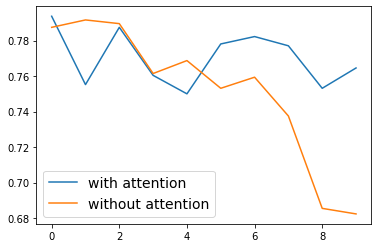

In [15]:
plt.plot(test_acc_atten)
plt.plot(test_acc_GCN)
plt.legend(["with attention", "without attention"], fontsize=14)